In [2]:
import numpy as np
from keras.utils import to_categorical
from sklearn import datasets
import matplotlib.pyplot as plt

Using TensorFlow backend.
D:\Anaconda\envs\pygmt\lib\site-packages\tensorflow\python\framework\dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda\envs\pygmt\lib\site-packages\tensorflow\python\framework\dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda\envs\pygmt\lib\site-packages\tensorflow\python\framework\dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda\envs\pygmt\lib\site-packages\tensorflow\python\framework\dtypes.py:461: Fu

In [12]:
class Layer(object):
    '''
    全连接层：中间层
    '''
    def __init__(self, input_dim, output_dim, activate='sigmoid'):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.W = np.random.normal(0,0.1,(input_dim, output_dim)) # W随机初始化: N(0,0.01)
        self.b = np.zeros((output_dim,)) # b初始化: 0
        self.act = activate

    def activate(self, a, grad=False):
        '''
        a: (batch_size, output_dim)
        return: (batch_size, output_dim)
        '''
        if self.act == 'sigmoid':
            h = 1/(1+np.exp(-a))
            if grad:
                return h*(1-h)
            return h
        elif self.act == 'tanh':
            h = np.tanh(a)
            if grad:
                return 1-h**2
            return h
        elif self.act == 'ReLU':
            h = np.piecewise(a, [a > 0, a <= 0], [lambda x: x, lambda x: 0]) + 0  # +0为了把array(x)转成x
            if grad:
                return np.piecewise(a, [a > 0, a <= 0], [lambda x: 1, lambda x: 0]) + 0 
            return h

    def forward(self, input_data):
        '''
        input_data: (batch_size, input_dim)
        return: (batch_size, output_dim)
        '''
        self.input_data = input_data
        self.a = self.input_data.dot(self.W) + self.b
        h = self.activate(self.a)
        return h

    def backward(self, input_grad, lr=0.01):
        '''
        BP in hidden layer
        input_grad: (batch_size, output_dim)  𝜕L/𝜕h for this layer
        return: (batch_size, input_dim)      𝜕L/𝜕h for previous layer
        '''
        batch_size = input_grad.shape[0]
        a_grad = self.activate(self.a, grad=True) * input_grad # 𝜕L/𝜕a (batch_size, output_dim)

        b_grad = a_grad.mean(axis=0) # 𝜕L/𝜕b (output_dim,)
        self.b -= lr * b_grad

        # 𝜕L/𝜕W (input_dim, output_dim)
        # (batch_size, 1, output_dim) * (batch_size, input_dim, 1) = (batch_size, input_dim, output_dim), then mean at axis=0
        W_grad = (a_grad.reshape(batch_size,1,self.output_dim)*self.input_data.reshape(batch_size,self.input_dim,1)).mean(axis=0)
        self.W -= lr * W_grad
    
        return a_grad.dot(self.W.T) 

In [13]:
class Output_layer(Layer):
    '''
    输出层：继承自中间层
    '''
    def __init__(self, input_dim, output_dim, activate='softmax'):
        super().__init__(input_dim, output_dim, activate='softmax')

    def activate(self, a):
        '''
        activate in output layer
        a: (batch_size, output_dim)
        return: (batch_size, output_dim)
            使用softmax默认使用cross entropy loss
            使用linear默认使用square loss
            这样使得输出层中：𝜕L/𝜕a = y_pred - y_train
        '''
        # softmax和linear对应分类/回归任务的输出层
        if self.act == 'softmax':
            h = np.exp(a)/(np.exp(a).sum(axis=1).reshape(a.shape[0],1)) 
            return h
        elif self.act == 'linear':
            return a
    
    def backward(self, input_grad, lr=0.01):
        '''
        BP in output layer
        input_grad: (batch_size, output_dim)  𝜕L/𝜕a for output layer, usually y_pred-y
        return: (batch_size, input_dim)       𝜕L/𝜕h for previous hidden layer
        '''
        batch_size = input_grad.shape[0]
        a_grad = input_grad          # 𝜕L/𝜕a (batch_size, output_dim)
        b_grad = a_grad.mean(axis=0) # 𝜕L/𝜕b (output_dim,)
        self.b -= lr * b_grad
        # 𝜕L/𝜕W (input_dim, output_dim)
        # (batch_size, 1, output_dim) * (batch_size, input_dim, 1) = (batch_size, input_dim, output_dim), then do average at axis=0
        W_grad = (a_grad.reshape(batch_size,1,self.output_dim)*self.input_data.reshape(batch_size,self.input_dim,1)).mean(axis=0)
        self.W -= lr * W_grad

        return input_grad.dot(self.W.T) 

In [27]:
# iris数据测试

iris = datasets.load_iris()
x = iris['data']
y = iris['target']
train_x = (x-x.mean(axis=0))/(x.std(axis=0))
train_y = to_categorical(y, num_classes=3)
print(x.shape, train_x.shape, y.shape, train_y.shape)

(150, 4) (150, 4) (150,) (150, 3)


In [28]:
# 单层softmax：逻辑回归多分类推广
ly = Output_layer(input_dim=4, output_dim=3, activate='softmax')

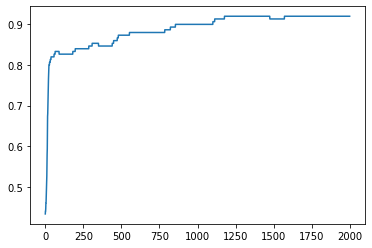

In [29]:
train_acc_set = []

for epoch in range(2000):
    y_pred = ly.forward(train_x)
    input_grad = y_pred - train_y # 𝜕L/𝜕a: softmax + cross_entropy
    g1 = ly.backward(input_grad)

    train_acc = (y_pred.argmax(axis=1)==y).sum()/y.size
    train_acc_set.append(train_acc)

plt.plot(train_acc_set)
plt.show()

In [51]:
import torch
B = torch.tensor((1,2,3),dtype=torch.float32,requires_grad=True)
B

tensor([1., 2., 3.], requires_grad=True)

In [52]:
y = B.pow(2).sum()
y.backward()
B.grad

tensor([2., 4., 6.])